# Bank marketing campaign | Predictive analytics

## Business Problem Understanding

### Background
Sebuah Bank swasta mengalami penurunan revenue, manajemen meminta tim Data Scientist untuk menemukan penyebab serta bisa menaikkan Revenue Bank tsb.

### Problem Statement
Setelah melakukan investigasi, tim menemukan permasalahan bahwa nasabah tidak melakukan deposit sesering sebelumnya, Deposito membuat Bank bisa memegang uang nasabah dalam jangka waktu tertentu sehingga Bank dapat menginvestasikan uang tersebut untuk beberapa produk bank yg dapat meningkatkan profit. Bank juga memiliki kesempatan lebih tinggi untuk membujuk nasabah depositio untuk membeli Produk Bank lain.

### Goals
Sesuai dengan analisa di atas, Bank ingin mengidentifikasi Nasabah yg memiliki kemungkinan besar untuk mendaftar Deposito, sehingga Bank bisa lebih mefokuskan usaha-effort dari tim Marketing

### Analytics Approach
Pendekatan analisis yg akan kita gunakan adalah Predictive Analytics, Kita akan membangun model klasifikasi yang akan membantu Bank untuk dapat memprediksi probabilitas seorang Nasabah akan/ingin mendaftar deposito atau tidak, Model akan digunakan sebelum tim marketing melakukan kontak dg Nasabah.

### Features  Overview

Feature description

Bank client data:

    1 - age (numeric)
    2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    5 - default: has credit in default? (categorical: 'no','yes','unknown')
    6 - housing: has housing loan? (categorical: 'no','yes','unknown')
    7 - loan: has personal loan? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:

    8 - contact: contact communication type (categorical: 'cellular','telephone')
    9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
    11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

    12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    14 - previous: number of contacts performed before this campaign and for this client (numeric)
    15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes

    16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
    17 - cons.price.idx: consumer price index - monthly indicator (numeric)
    18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
    19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
    20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

    21 - y - has the client subscribed a term deposit? (binary: 'yes','no')



## Evaluation Metrics

<img src='Eva_Metrics.png'>



Type 1 error : False Positive

Konsekuensi: sia-sianya biaya komunikasi, waktu dan sumber daya lain

Type 2 error : False Negative

Konsekuensi: kehilangan nasabah potensial

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi cost marketing dari perusahaan tersebut, tetapi tanpa membuat menjadi kurangnya nasabah potensial yang dibutuhkan perusahaan. Jadi harus kita seimbangkan nanti antara precision dan recallnya dari kelas positive. Jadi nanti metric utama yang akan kita gunakan adalah roc_auc.


### Import Package

In [60]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


## Model Evaluation
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [2]:
#Load Dataset
df = pd.read_csv("bank.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Overview Data

In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

Melakukan Pengecekan Distribusi Data (balance atau imbalance)

In [4]:
df.y.value_counts()/len(df)*100

no     88.734583
yes    11.265417
Name: y, dtype: float64

Terlihat disini data Imbalance

In [5]:
# Encoding the Target
df['y'] = df['y'].replace({"yes" : 1, "no" : 0})

Melakukan Encoding target

In [6]:
## Overview Feature
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,78,"[45, 40]"
1,job,object,0,0.0,12,"[unknown, management]"
2,marital,object,0,0.0,4,"[single, married]"
3,education,object,0,0.0,8,"[unknown, basic.4y]"
4,default,object,0,0.0,3,"[no, unknown]"
5,housing,object,0,0.0,3,"[yes, unknown]"
6,loan,object,0,0.0,3,"[yes, unknown]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,month,object,0,0.0,10,"[nov, aug]"
9,day_of_week,object,0,0.0,5,"[wed, thu]"


Melakukan pengecekan Missing value

In [7]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Sesuai data di atas, tidak ada Missing value di dataset kita, hanya saja ada beberapa data 'Unknown' yg bisa kita asumsikan sebagai Missing value

## Data Preparation

Melakukan pengecekan Deskriptif Statistik

In [8]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [9]:
df.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


Kita akan menghapus beberapa kolom yg data nya tidak bisa kita dapatkan ketika me-running model (Data didapatkan setelah Tim marketing kontak), sedangkan model digunakan sebelum tim marketing melakukan Kontak ke Nasabah,
Beberapa kolom yg akan dihapus
- duration
- month
- day_of_week

kita juga akan menghapus kolom yg berkaitan dengan socio ekonomi, karena kolom ini tidak berkaitan langsung dengan Nasabah,
Kolom tersebut adalah
- emp.var.rate
- cons.price.idx
- cons.conf.idx
- euribor3m
- nr.employed

In [10]:
df_1 = df.drop(columns=['duration', 'month', 'day_of_week', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                       'euribor3m', 'nr.employed'], axis=1)

## Handling Unknown value

Dataframe yg akan kita gunakan selanjutnya adalah `df_1`

Beberapa kolom kategori ada yg memiliki value `unknown` sehingga kita akan handle data dg value tersebut

In [11]:
df_1.job.value_counts()['unknown']/len(df_1) * 100

0.8012042342429834

In [12]:
df_1.marital.value_counts()['unknown']/len(df_1) * 100

0.1942313295134505

In [13]:
df_1.education.value_counts()['unknown']/len(df_1) * 100

4.202680392347285

In [14]:
df_1.default.value_counts()['unknown']/len(df_1) * 100

20.87258424783918

In [15]:
df_1.housing.value_counts()['unknown']/len(df_1) * 100

2.40361270272895

In [16]:
df_1.loan.value_counts()['unknown']/len(df_1) * 100

2.40361270272895

Untuk data yg memiliki Job, marital, education, housing, loan = `Unknown` akan kita Drop, karena secara persentase masih Kecil

In [17]:
df_1 = df_1[(df_1['loan'] != 'unknown') & (df_1['job'] != 'unknown') & (df_1['marital'] != 'unknown') & (df_1['education'] != 'unknown') & (df_1['housing'] != 'unknown')]

Untuk Kolom Default, data `unknown` akan kita kategorikan ke dalam `no` karena asumsinya adalah Nasabah tersebut tidak pernah menunggak

In [18]:
df_1 = df_1.replace({'unknown' : 'no'})

In [19]:
listItem = []
for col in df_1.columns :
    listItem.append([col, df_1[col].dtype, df_1[col].isna().sum(), round((df_1[col].isna().sum()/len(df_1[col])) * 100,2),
                    df_1[col].nunique(), list(df_1[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,77,"[47, 81]"
1,job,object,0,0.0,11,"[admin., entrepreneur]"
2,marital,object,0,0.0,3,"[divorced, married]"
3,education,object,0,0.0,7,"[illiterate, university.degree]"
4,default,object,0,0.0,2,"[no, yes]"
5,housing,object,0,0.0,2,"[yes, no]"
6,loan,object,0,0.0,2,"[yes, no]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,campaign,int64,0,0.0,41,"[5, 39]"
9,pdays,int64,0,0.0,26,"[7, 18]"


## Feature Engineering

In [20]:
df_1.pdays.unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   9,  11,   2,   8,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27],
      dtype=int64)

Encoding pdays, untuk 999 menjadi 0(No) dan yg lain menjadi 1 (yes)

In [22]:
def enc_pdays(x):
    if x == 999:
        return 0
    else:
        return 1

In [23]:
df_1['pdays'] = df_1['pdays'].apply(enc_pdays)

In [24]:
df_1.education.unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree', 'illiterate'],
      dtype=object)

In [26]:
ed =['basic.9y','basic.6y','basic.4y']
for i in ed:
    df_1.loc[df_1['education'] == i, 'education'] = "middle.school"

df_1['education'].value_counts()

middle.school          12062
university.degree      11821
high.school             9244
professional.course     5100
illiterate                18
Name: education, dtype: int64

Encoding Default, Housing & Loan: Yes : 1 dan No : 0

In [28]:
col = ['default', 'housing', 'loan']
for i in col:
    df_1[i] = df_1[i].map({'yes' : 1, 'no' : 0})

In [29]:
df_1['age'].unique()

array([56, 57, 37, 40, 45, 59, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55, 41,
       34, 52, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 49, 31, 43, 58, 36,
       28, 27, 26, 22, 23, 20, 21, 19, 18, 70, 61, 66, 76, 67, 73, 88, 95,
       68, 75, 63, 80, 62, 65, 72, 64, 71, 69, 78, 85, 79, 77, 83, 81, 74,
       82, 17, 87, 91, 98, 94, 86, 84, 89], dtype=int64)

In [30]:
df_1['age'].min()

17

Kita akan mengelompokkan Usia ke kelompok tertentu

In [31]:
bins = [16, 32, 47, 100]
label = ['Young', 'Adult', 'Elder']

In [32]:
df_1['age'] = pd.cut(df_1['age'], bins=bins, labels=label)

In [33]:
df_1['age'].value_counts()

Adult    18808
Young    10498
Elder     8939
Name: age, dtype: int64

Kita akan melakukan Encoding kelompok usia tersebut

In [34]:
df_1['age'] = df_1['age'].map({'Young' : 0, 'Adult' : 1, 'Elder' : 2})

Kita akan melakukan Encoding Feature Education

In [35]:
df_1['education'].value_counts()

middle.school          12062
university.degree      11821
high.school             9244
professional.course     5100
illiterate                18
Name: education, dtype: int64

In [37]:
df_1['education'] = df_1['education'].map({
    'illiterate' : 0,
    'middle.school' : 1,
    'high.school' : 2,
    'university.degree' : 3,
    'professional.course' : 4
})

Kota juga akan melakukan Binary Encoding untuk Kolom Contact

In [43]:
df_1['contact'] = df_1['contact'].map({'telephone' : 0, 'cellular' : 1})

In [38]:
listItem = []
for col in df_1.columns :
    listItem.append([col, df_1[col].dtype, df_1[col].isna().sum(), round((df_1[col].isna().sum()/len(df_1[col])) * 100,2),
                    df_1[col].nunique(), list(df_1[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,category,0,0.0,3,"[2, 1]"
1,job,object,0,0.0,11,"[services, housemaid]"
2,marital,object,0,0.0,3,"[divorced, single]"
3,education,int64,0,0.0,5,"[3, 4]"
4,default,int64,0,0.0,2,"[1, 0]"
5,housing,int64,0,0.0,2,"[0, 1]"
6,loan,int64,0,0.0,2,"[1, 0]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,campaign,int64,0,0.0,41,"[27, 21]"
9,pdays,int64,0,0.0,2,"[0, 1]"


Kita akan melakukan One Hot Encoding untuk kolom Job, Marital dan Poutcome

In [44]:
df_1 = pd.get_dummies(df_1, columns=['job', 'marital', 'poutcome'], drop_first=True)

In [45]:
df_1.head()

,age,education,default,housing,loan,contact,campaign,pdays,previous,y,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,poutcome_nonexistent,poutcome_success
0,2,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2,2,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,1,2,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,2,2,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0


# Machine Learning Modelling

## Dataset Splitting

In [46]:
X = df_1.drop(columns='y')
y = df_1.y

In [102]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
print(X_train.shape, X_test.shape)

(30596, 23) (7649, 23)


## Modelling & Evaluation

In [52]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xt = ExtraTreesClassifier()

In [54]:
models = [logreg,knn,dt, rf, xt]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=4)
    estimator=Pipeline([
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'DT', 'RF', 'XT'],'mean roc_auc':rata,'sdev':std})

,model,mean roc_auc,sdev
0,Logistic Regression,0.717443,0.002793
1,KNN,0.626607,0.002942
2,DT,0.597960,0.010416
3,RF,0.647804,0.003738
4,XT,0.628896,0.006540


Terlihat bahwa model Logistic Regression adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter

## Model BenchMarking Test Data

In [55]:
models = [logreg,knn,dt,rf, xt]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Xtra Tree']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Xtra Tree'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      6797
           1       0.67      0.19      0.30       852

    accuracy                           0.90      7649
   macro avg       0.79      0.59      0.62      7649
weighted avg       0.88      0.90      0.87      7649

KNN 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      6797
           1       0.50      0.18      0.27       852

    accuracy                           0.89      7649
   macro avg       0.70      0.58      0.60      7649
weighted avg       0.86      0.89      0.86      7649

Decision Tree 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      6797
           1       0.39      0.15      0.22       852

    accuracy                           0.88      7649
   macro avg       0.65      0.56      0.58      7649
weighted avg       0.84      0

,roc_auc score
model,
Logistic Regression,0.721097
Random Forest,0.648625
Xtra Tree,0.627156
KNN,0.626359
Decision Tree,0.603944


Terlihat kembali lagi model Logistic Regression adalah yang terbaik performanya pada test data.

Mari sekarang kita coba melakukan Hyper Parameter Tuning untuk model LogReg kita untuk melihat apakah kita dapat mendapatkan hasil yang lebih baik lagi.

## Test Oversampling with K-Fold Cross Validation

In [56]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [57]:
from sklearn.model_selection import StratifiedKFold
K = 5
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [58]:
data = X_train
target = y_train

In [97]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lr = LogisticRegression()
    estimator=Pipeline([
        
        ('model',lr)
    ])
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

## Evaluation Metrics Without Oversampling

In [95]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate



,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.897205,0.897059,0.714830,0.737708,0.611047,0.612692,0.177313,0.180352,0.637203,0.634021
1,0.896556,0.901128,0.717887,0.726196,0.605010,0.630005,0.168073,0.202643,0.633472,0.690000
2,0.897945,0.894917,0.721062,0.712576,0.615462,0.600907,0.183486,0.164464,0.646831,0.602151
3,0.898027,0.894591,0.724972,0.695444,0.615160,0.602208,0.182752,0.167401,0.649283,0.593750
4,0.897128,0.898840,0.721259,0.712181,0.613403,0.613330,0.181651,0.177680,0.632184,0.672222
Average,0.897372,0.897307,0.720002,0.716821,0.612016,0.611828,0.178655,0.178508,0.639794,0.638429


## Evaluation Metrics With Oversampling

In [98]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.649940,0.702288,0.718972,0.737121,0.648802,0.564313,0.593003,0.626100,0.669209,0.214142
1,0.646906,0.672332,0.715965,0.724352,0.646619,0.542465,0.618426,0.627019,0.655779,0.196051
2,0.652699,0.693414,0.720432,0.712446,0.651811,0.550896,0.602197,0.584435,0.669854,0.199900
3,0.658606,0.680176,0.726602,0.695197,0.657992,0.539742,0.616219,0.574156,0.673297,0.189990
4,0.653365,0.683118,0.719495,0.713094,0.652792,0.546326,0.612725,0.602056,0.666934,0.197305
Average,0.652303,0.686266,0.720293,0.716442,0.651603,0.548749,0.608514,0.602753,0.667015,0.199478


Terlihat bahwa hasil evaluation metricsnya untuk recall dari class positive lebih baik setelah di oversampling dari yang tidak di oversampling tetapi precisionn class positive menjadi sedikit lebih buruk.

Ini masuk akal karena class positive datanya kita perbanyak menjadi sama dengan jumlah data dari class negative, dimana ini biasa memang akan membuat recall dari class yg minoritas naik tetapi seringnya precisionnya juga akan turun sebagai dampaknya (Recall dan Precision Trade off). Tetapi untuk kasus kali ini recallnya naik lebih tinggi dari pada precisionnya yang turun. Dan dampak ini terhadap kasus permasalahan kita berarti model kita setelah di oversampling, menjadi mendapatkan potensial nasabah yang lebih banyak dari sebelumnya, tetapi sedikit berkurang dalam ketepatan/precision tebakannya untuk nasabah potensial, yang menyebabkan cost biaya marketing yang terbuang menjadi lebih tinggi dari model yang tidak di oversampling.

Sekarang pertanyaannya, model manakah yang lebih baik dan harus kita gunakan? menentukan ini kembali lagi tergantung permasalahan yang sedang dihadapi dan berdasarkan pengertian/pengalaman terhadap domain permasalahannya. Dimana untuk permasalahan kali ini, yang perlu kita perhatikan dan ketahui adalah apakah selama ini nasabah yang potensial itu sudah terlalu banyak dan kita tidak butuh semuanya, atau nasabah yang potensial itu masih pas-pasan atau bahkan kurang. Bila kasus yang pertama yg terjadi (nasabah potensial yang terlalu banyak) maka kita dapat menggunakan model yang tanpa oversampling saja (precision lebih penting dari recall), dan bila kasus yang kedua yg terjadi (nasabah potensial yg pas-pasan atau kurang) maka kita dapat menggunakan model yang menggunakan oversampling (recall lebih penting dari precision).

Dimana intinya, pemilihan model yang digunakan harus berdasarkan permasalahan yang dihadapi dan yang dapat menyelesaikan masalahnya paling baik (berdampak paling baik terhadap bisnis/organisasi yang bersangkutan (stakeholdernya)).

Mari sekarang kita lihat juga classification reportsnya.

## Classification Reports Without Oversampling

In [65]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      5438
           1       0.63      0.18      0.28       682

    accuracy                           0.90      6120
   macro avg       0.77      0.58      0.61      6120
weighted avg       0.88      0.90      0.87      6120

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5438
           1       0.69      0.20      0.31       681

    accuracy                           0.90      6119
   macro avg       0.80      0.60      0.63      6119
weighted avg       0.88      0.90      0.88      6119

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      5438
           1       0.60      0.16      0.26       681

    accuracy                           0.89      6119
   macro avg       0.75      0.58      0.60      6119
weighted avg       0.87      0.89      0.87      6119

              preci

## Classification Reports With Oversampling

In [99]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.94      0.71      0.81      5438
           1       0.21      0.63      0.32       682

    accuracy                           0.70      6120
   macro avg       0.58      0.67      0.56      6120
weighted avg       0.86      0.70      0.75      6120

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      5438
           1       0.20      0.63      0.30       681

    accuracy                           0.67      6119
   macro avg       0.57      0.65      0.54      6119
weighted avg       0.85      0.67      0.73      6119

              precision    recall  f1-score   support

           0       0.93      0.71      0.80      5438
           1       0.20      0.58      0.30       681

    accuracy                           0.69      6119
   macro avg       0.57      0.65      0.55      6119
weighted avg       0.85      0.69      0.75      6119

              preci

Terlihat bahwa model yang setelah di oversampling memiliki recall dari kedua class yang lebih seimbang. Oleh karena itu untuk kasus kali ini, mari kita gunakan model yang menggunakan oversampling (menggunakan asumsi yang kedua (yaitu kita membutuhkan nasabah potensial yang lebih banyak)).

Sekarang mari kita coba melakukan hyperparameter tuning pada model Logistic Regression kita untuk mendapatkan hasil yang lebih baik lagi.

## Hyper Parameter Tuning

In [88]:
lr = LogisticRegression()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('model',lr)
])

In [89]:
hyperparam_space=[{
    'model__C': [0.1, 0.075, 0.125, 0.05],
    'model__l1_ratio': np.arange(0,1,0.1),
    'model__class_weight' : [{0: x, 1: 1-x} for x in [0.1, 0.25, 0.3, 0.20]]
}]

In [90]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=3)

In [91]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('oversampling',
                                        RandomOverSampler(random_state=42,
                                                          ratio=None,
                                                          return_indices=False,
                                                          sampling_strategy='auto')),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                       

## Training Best Model

In [103]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('oversampling',
                 RandomOverSampler(random_state=42, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('model',
                 LogisticRegression(C=0.075, class_weight={0: 0.3, 1: 0.7},
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=0.0,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [104]:
estimator=Pipeline([
    ('oversampling',ros),
    ('model',lr)
])
estimator.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('oversampling',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [105]:
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LogReg : ', roc_auc_default)
print('ROC AUC Score Tuned LogReg : ', roc_auc_tuned)

ROC AUC Score Default LogReg :  0.7198357498233479
ROC AUC Score Tuned LogReg :  0.7210647164829003


Terlihat bahwa model LogReg setelah kita tuning hyperparameternya memiliki nilai ROC AUC yang lebih baik walaupun hanya naik sedikit saja.

Mari kita lihat juga perbandingan classification reportnya

In [106]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LogReg : \n', report_default)
print('Classification Report Tuned LogReg : \n', report_tuned)

Classification Report Default LogReg : 
               precision    recall  f1-score   support

           0       0.93      0.69      0.80      6797
           1       0.20      0.60      0.29       852

    accuracy                           0.68      7649
   macro avg       0.56      0.64      0.55      7649
weighted avg       0.85      0.68      0.74      7649

Classification Report Tuned LogReg : 
               precision    recall  f1-score   support

           0       0.96      0.24      0.39      6797
           1       0.13      0.93      0.23       852

    accuracy                           0.32      7649
   macro avg       0.55      0.59      0.31      7649
weighted avg       0.87      0.32      0.37      7649



Kembali lagi terlihat bahwa model LogReg setelah kita tuning hyperparameternya memiliki classification report yang lebih baik terutama Recall untuk positive class. Oleh karena itu kita akan menggunakan model LogReg yang sudah di tuned sebagai model akhir kita.

## Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model LogReg kita menggunakan Coefficient


In [129]:
pd.DataFrame(data = best_model['model'].coef_.reshape(23,1), index = [X_train.columns], columns =['Coeff']).sort_values(by ='Coeff', ascending=False)[:10]

,Coeff
pdays,1.185618
poutcome_success,1.053822
contact,0.840463
job_retired,0.774992
job_student,0.631790
previous,0.340668
poutcome_nonexistent,0.261971
marital_single,0.218440
education,0.063156
marital_married,0.025776


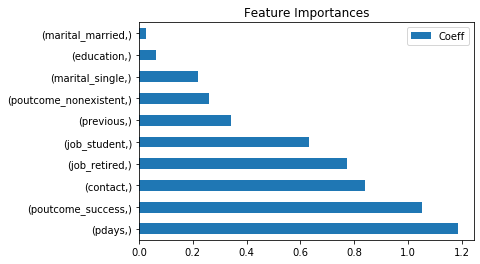

In [133]:
coef1 = pd.DataFrame(data = best_model['model'].coef_.reshape(23,1), index = [X_train.columns], columns =['Coeff']).sort_values(by ='Coeff', ascending=False)[:10]
coef1.plot(kind='barh', title='Feature Importances');

Terlihat bahwa ternyata untuk model LogReg kita, fitur/kolom pdays adalah yang paling penting, kemudian diikuti dengan poutcome_success, contact, dan selanjutnya.

## Conclusion & Recommendation

In [134]:
print('Classification Report Tuned LogReg : \n', report_tuned)

Classification Report Tuned LogReg : 
               precision    recall  f1-score   support

           0       0.96      0.24      0.39      6797
           1       0.13      0.93      0.23       852

    accuracy                           0.32      7649
   macro avg       0.55      0.59      0.31      7649
weighted avg       0.87      0.32      0.37      7649



**Conclusion**




Berdasarkan hasil classification report dari model kita, kita dapat menyimpulkan/mengambil konklusi bahwa bila seandainya nanti kita menggunakan model kita untuk memfilter/menyaring list nasabah yang akan kita coba tawarkan, maka model kita dapat mengurangi 24% kandidat yang tidak tertarik untuk tidak kita approach, dan model kita dapat mendapatkan 93% nasabah yang tertarik dari seluruh nasabah yang tertarik. (semua ini berdasarkan recallnya)


**Simulasi**


Bila kita asumsikan dalam satu bulan marketing akan menghubungi 400 orang, 100 orang setiap minggu, dan jika ada 200 orang yg aktual nya tertarik sedangkan 200 orang aktual tidak tertarik, tanpa menggunakan model kita akan mendapatkan 200 orang yg tertarik dalam waktu 1 bulan penuh (semua nasabah dihubungi), tetapi jika menggunakan model, dalam 2 minggu pertama kita bisa mendapatkan 93% dari 200 aktual atau sekitar 186 orang, dan jika dalam 2 minggu berikutnya bisa gunakan untuk menambah nasabah lagi, jika kita asumsikan dg jumlah yg sama, maka dalam 1 bulan, jika tanpa menggunakan model kita akan mendapatkan 200 nasabah, sedangkan jika menggunakan model kita bisa mendapatkan 186 + 186 = 372 nasabah.

Keuntungan yg di dapatkan dalam 1 bulan jika tanpa Model :
Profit dari perbankan adalah selisih antara Bunga kredit pinjaman dikurangi Bunga Deposito yg diberikan ke nasabah.
Berdasarkan Bunga Deposito di https://www.bankmandiri.co.id/web/guest/suku-bunga-dana#deposito, kita gunakan Bunga depositio Bank Mandiri 2.5% (tenor 1 tahun) dan berdasarkan https://www.ojk.go.id/id/kanal/perbankan/pages/suku-bunga-dasar.aspx, kita gunakan Kredit Mikro dari bank Mandiri sebesar 11.25%, maka Keuntungan yg di dapatkan Bank adalah 11.25% - 2.5% = 8.75%. Dengan minimum deposito sesuai di link referensi (https://www.bankmandiri.co.id/web/guest/suku-bunga-dana#deposito) adalah 10.000.0000, maka :

Tanpa Model (semua nasabah dihubungi - Perhitungan asumsi dalam 1 bulan)

    Keuntungan Minimum per Nasabah : 10.000.000 x 8.75% = 875.000
    Keuntungan Minimum dalam 1 bulan : 200 nasabah x 875.000 = 175.000.000

Dengan Menggunakan Model :

    Kita bisa mendapatkan Total nasabah 186 + 186 = 372
    Keuntungan minimum dalam 1 bulan : 372 nasabah x 875.000 = 325.500.000
    
Selisih Keuntungan yg didapatkan ketika kita menggunakan model dibandingkan jika kita tidak menggunakan model adalah :

    325.000.000 - 175.000.000 = 150.500.000 (ini merupakan Keuntungan Minimal dg asumsi Nasabah menyimpan deposito 10 juta)

**Recommendation**

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :

- Menambahkan kolom Saldo Nasabah agar kita bisa melakukan penyaringan awal, nasabah mana yg potensial berdasarkan range Saldo Bank nasabah tersebut..
- Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan ketertarikannya, seperti alamat nasabah, gaji atau pendapatannya sekarang, jabatan pekerjaannya sekarang (apakah karyawan, manager, direktur, dan sebagainya), tunjangan apa saja yang didapatkan ditempat kerjanya sekarang, dll.
- Mencoba algorithm ML yang lain dan juga mencoba hyperparameter tuning kembali, coba gunakan teknik oversampling yang berbeda juga selain Random Over Sampling, seperti SMOTE, dll.
- Menganalisa data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.